### Import Dependencies

In [2]:
# Dependencies
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn import datasets


# Import the OpenWeatherMap API key
from config import nd_apikey

ModuleNotFoundError: No module named 'config'

### Import base dataset and cleanup

In [3]:
# Set path for the data file
ffolder = "Resources/"
movies_file = f"{ffolder}top-500-movies.csv"
cpi_file = f"{ffolder}cpivalues.csv"

# Read data into pandas Dataframe and preview table
base_df = pd.read_csv(movies_file)

base_df.head()

,rank,release_date,title,url,production_cost,domestic_gross,worldwide_gross,opening_weekend,mpaa,genre,theaters,runtime,year
0,1,4/23/2019,Avengers: Endgame,/movie/Avengers-Endgame-(2019)#tab=summary,400000000,858373000,2797800564,357115007.0,PG-13,Action,4662.0,181.0,2019.0
1,2,5/20/2011,Pirates of the Caribbean: On Stranger Tides,/movie/Pirates-of-the-Caribbean-On-Stranger-Ti...,379000000,241071802,1045713802,90151958.0,PG-13,Adventure,4164.0,136.0,2011.0
2,3,4/22/2015,Avengers: Age of Ultron,/movie/Avengers-Age-of-Ultron#tab=summary,365000000,459005868,1395316979,191271109.0,PG-13,Action,4276.0,141.0,2015.0
3,4,12/16/2015,Star Wars Ep. VII: The Force Awakens,/movie/Star-Wars-Ep-VII-The-Force-Awakens#tab=...,306000000,936662225,2064615817,247966675.0,PG-13,Adventure,4134.0,136.0,2015.0
4,5,4/25/2018,Avengers: Infinity War,/movie/Avengers-Infinity-War#tab=summary,300000000,678815482,2048359754,257698183.0,PG-13,Action,4474.0,156.0,2018.0


In [4]:
current_year = datetime.datetime.now().year

# Filter rows where: production_cost = 0 or domestic_gross = 0 or year > current-year or year = 0 or title = blanks
# Select all columns except url, opening_weekend and year
yearne0 = (base_df['year'] > 0)
year_ok = (base_df['year'] <= current_year)
prodcost_ok = (base_df['production_cost'] > 0)
domgross_ok = (base_df['domestic_gross'] > 0)
title_ok = (base_df['title'] != "")
reldate_ok = (base_df['release_date'] != "")

filtered_df = base_df.loc[(reldate_ok & title_ok & prodcost_ok & domgross_ok & yearne0 & year_ok),                          
                ['rank', 'release_date', 'title', 'production_cost', 'domestic_gross', 'worldwide_gross', 
                 'mpaa', 'genre', 'theaters', 'runtime']]

# we need not look into genre and mpaa as genre is 99% Adventure and mpaa is not holding much value here

filtered_df.count()

# que to team - do we need to filter rows where theaters = 0 and runtime = 0?

rank               484
release_date       484
title              484
production_cost    484
domestic_gross     484
worldwide_gross    484
mpaa               480
genre              480
theaters           479
runtime            474
dtype: int64

In [5]:
# Convert datatype to datetime for release date column
filtered_df["release_date"] = pd.to_datetime(filtered_df["release_date"])

# New column for YearMonth and Year from Release_date
filtered_df["YearMonth"] = pd.to_datetime(filtered_df['release_date']).dt.strftime('%Y%m')
filtered_df["Year"] = pd.to_datetime(filtered_df['release_date']).dt.strftime('%Y')
filtered_df["Month"] = pd.to_datetime(filtered_df['release_date']).dt.strftime('%m')

# Change datatype of columns to int
filtered_df["YearMonth"] = filtered_df["YearMonth"].astype(int)
filtered_df["Year"] = filtered_df["Year"].astype(int)
filtered_df["Month"] = filtered_df["Month"].astype(int)
filtered_df.head()

,rank,release_date,title,production_cost,domestic_gross,worldwide_gross,mpaa,genre,theaters,runtime,YearMonth,Year,Month
0,1,2019-04-23,Avengers: Endgame,400000000,858373000,2797800564,PG-13,Action,4662.0,181.0,201904,2019,4
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,379000000,241071802,1045713802,PG-13,Adventure,4164.0,136.0,201105,2011,5
2,3,2015-04-22,Avengers: Age of Ultron,365000000,459005868,1395316979,PG-13,Action,4276.0,141.0,201504,2015,4
3,4,2015-12-16,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2064615817,PG-13,Adventure,4134.0,136.0,201512,2015,12
4,5,2018-04-25,Avengers: Infinity War,300000000,678815482,2048359754,PG-13,Action,4474.0,156.0,201804,2018,4


In [6]:
# Define function to get CPI values using API and store as csv in Resources folder
def get_cpivalues(min_yr):

    # get starting and ending dates for api parms
    # min=Jan first of year passed
    start_date = f"{min_yr}-01-01"
    # max=current date
    end_date = f"{datetime.datetime.now().date()}"
    
    base_url = "https://data.nasdaq.com/api/v3/datasets/RATEINF/CPI_USA.csv?"    
    url = f"{base_url}api_key={nd_apikey}&start_date={start_date}&end_date={end_date}"
    
    response_df = pd.read_csv(url)
    # Column date will be object (string) type - convert to datetime64
    response_df['Date'] = pd.to_datetime(response_df['Date'])

    # Add new column CPI_YYYYMM
    response_df['CPI_YYYYMM'] = pd.to_datetime(response_df['Date']).dt.strftime('%Y%m')

    # Save file as .csv to Resources folder for later use
    newfile = 'Resources/cpivalues.csv'
    response_df.to_csv(newfile, index=False)

In [7]:
min_year = filtered_df['Year'].min()
# Check for cpivalues.csv file in Resources folder. If not found, call API to get CPI values
csv_file = Path(cpi_file)
if csv_file.exists():
    cpi_df = pd.read_csv(csv_file)
else:
    get_cpivalues(min_year)
    cpi_df = pd.read_csv(csv_file)
    
# Get latest (max date) CPI value 
current_cpi = cpi_df.iloc[cpi_df['CPI_YYYYMM'].idxmax(), 1]

# Merge 2 dataframes on YearMonth/CPI_YYYYMM columns
merged_df = pd.merge(filtered_df, cpi_df, left_on="YearMonth", right_on="CPI_YYYYMM")
merged_df.head()

,rank,release_date,title,production_cost,domestic_gross,worldwide_gross,mpaa,genre,theaters,runtime,YearMonth,Year,Month,Date,Value,CPI_YYYYMM
0,1,2019-04-23,Avengers: Endgame,400000000,858373000,2797800564,PG-13,Action,4662.0,181.0,201904,2019,4,2019-04-30,255.548,201904
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,379000000,241071802,1045713802,PG-13,Adventure,4164.0,136.0,201105,2011,5,2011-05-31,225.964,201105
2,211,2011-05-26,Kung Fu Panda 2,150000000,165249063,664837547,PG,Adventure,3952.0,90.0,201105,2011,5,2011-05-31,225.964,201105
3,3,2015-04-22,Avengers: Age of Ultron,365000000,459005868,1395316979,PG-13,Action,4276.0,141.0,201504,2015,4,2015-04-30,236.599,201504
4,90,2015-04-01,Furious 7,190000000,353007020,1514553486,PG-13,Action,4022.0,137.0,201504,2015,4,2015-04-30,236.599,201504


In [40]:
# Create new columns for inflation adjustment for Production_cost, domestic and worldwide profits
merged_df['adjusted_production_cost'] = (merged_df['production_cost'] * (current_cpi/merged_df['Value'])).round()
merged_df['adjusted_domestic_gross'] = (merged_df['domestic_gross'] * (current_cpi/merged_df['Value'])).round()
merged_df['adjusted_worldwide_gross'] = (merged_df['worldwide_gross'] * (current_cpi/merged_df['Value'])).round()

# Create new dataframe with required columns and rename column
movies_df = merged_df[['rank', 'release_date', 'title', 'production_cost', 'adjusted_production_cost',
                      'domestic_gross', 'adjusted_domestic_gross', 'worldwide_gross', 'adjusted_worldwide_gross',
                      'theaters', 'runtime', 'Year', 'Month' 
                     ]]
movies_df.head()

,rank,release_date,title,production_cost,adjusted_production_cost,domestic_gross,adjusted_domestic_gross,worldwide_gross,adjusted_worldwide_gross,theaters,runtime,Year,Month
0,1,2019-04-23,Avengers: Endgame,400000000,466467356.0,858373000,1.001007e+09,2797800564,3.262707e+09,4662.0,181.0,2019,4
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,379000000,499843108.0,241071802,3.179369e+08,1045713802,1.379137e+09,4164.0,136.0,2011,5
2,211,2011-05-26,Kung Fu Panda 2,150000000,197827088.0,165249063,2.179383e+08,664837547,8.768192e+08,3952.0,90.0,2011,5
3,3,2015-04-22,Avengers: Age of Ultron,365000000,459741504.0,459005868,5.781481e+08,1395316979,1.757493e+09,4276.0,141.0,2015,4
4,90,2015-04-01,Furious 7,190000000,239317495.0,353007020,4.446356e+08,1514553486,1.907680e+09,4022.0,137.0,2015,4


In [9]:
#Relationship between production cost and gross revenue (domestic gross and Worldwide gross)
#Visualize: Production Cost Vs domestic gross (also worldwide gross) Scatter Plots, Linear Regression
#Response: Should we make high budget or low budget movies in a year? Is there a relation between huge production
#costs vs revenue? any association ? r-squared value (variance percent) between the dependent and 
#independent variables

/var/folders/ln/kt83gzyx0csgmdyxk3116rwh0000gn/T/ipykernel_44877/2425824713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['binned'] = pd.cut(movies_df['production_cost'], bins=[0,100000000,200000000,285000000,385000000,50000000000])


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

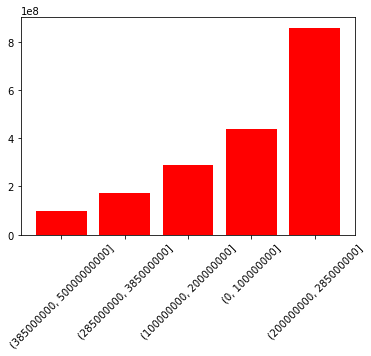

In [75]:
#Stacked Bar plot, Budget Vs domestic_gross and worldwide gross for top 25 movies
movies_df['binned'] = pd.cut(movies_df['production_cost'], bins=[0,100000000,200000000,285000000,385000000,50000000000])
y_values = movies_df.groupby(['binned'])['domestic_gross'].mean()
x=movies_df.binned.unique().astype(str)
plt.bar(x,  y_values.values, color = 'red')
plt.xticks(rotation = 45)

#topmovies_df = movies_df.loc[(movies_df.production_cost> 285000000)  & 
                                  #(movies_df.domestic_gross >= 28500000)]
#topmovies_df.groupby(['production_cost','domestic_gross']).size().unstack().plot(kind='bar', stacked = True)

In [72]:
movies_df['production_cost'].describe()

count    4.840000e+02
mean     1.494229e+08
std      4.765210e+07
min      9.100000e+07
25%      1.100000e+08
50%      1.400000e+08
75%      1.750000e+08
max      4.000000e+08
Name: production_cost, dtype: float64

In [71]:
y_values

binned
(0, 500000]                          NaN
(500000, 5000000]                    NaN
(5000000, 20000000]                  NaN
(20000000, 285000000]       1.699438e+08
(285000000, 385000000]      4.362963e+08
(385000000, 50000000000]    8.583730e+08
Name: domestic_gross, dtype: float64

In [63]:
y1_values

binned
(90691000.0, 168250000.0]     3.770206e+08
(168250000.0, 245500000.0]    6.475732e+08
(245500000.0, 322750000.0]    1.020594e+09
(322750000.0, 400000000.0]    1.746277e+09
Name: worldwide_gross, dtype: float64

In [65]:
x

[(322750000.0, 400000000.0], (90691000.0, 168250000.0], (168250000.0, 245500000.0], (245500000.0, 322750000.0]]
Categories (4, interval[float64, right]): [(90691000.0, 168250000.0] < (168250000.0, 245500000.0] < (245500000.0, 322750000.0] < (322750000.0, 400000000.0]]

In [ ]:
#Response Analysis: Type Here: 

In [57]:
y_values[1]


production_cost
91000000    5.823684e+07
92000000    9.030349e+07
92500000    7.119505e+07
93000000    2.244904e+08
94000000    2.720660e+08
95000000    8.552689e+07
97000000    7.599627e+07
97600000    1.176244e+08
98000000    2.020076e+08
99000000    8.893652e+07
Name: domestic_gross, dtype: float64

In [ ]:
Analysis Response Here: Type Here

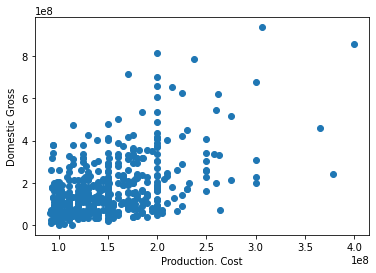

In [12]:
#Scatter Plot of Production Cost vs Domestic Gross Revenue
x_values = movies_df['production_cost']
y_values = movies_df['domestic_gross']
plt.scatter(x_values,y_values)
plt.xlabel('Production. Cost')
plt.ylabel('Domestic Gross')
plt.show()


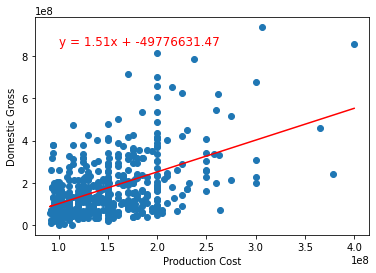

In [82]:
#linear regression Model
x_values = movies_df['production_cost']
y_values = movies_df['domestic_gross']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1.0e8,8.5e8),fontsize=12,color="red")
plt.xlabel('Production Cost')
plt.ylabel('Domestic Gross')
plt.show()

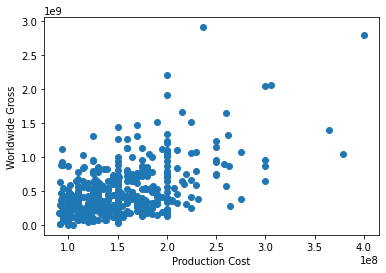

In [14]:
#Scatter Plot of Production Cost vs Worldwide Gross
x_values = movies_df['production_cost']
y_values = movies_df['worldwide_gross']
plt.scatter(x_values,y_values)
plt.xlabel('Production Cost')
plt.ylabel('Worldwide Gross')
plt.show()


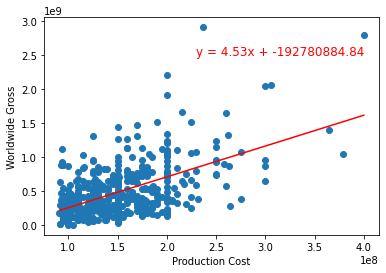

In [98]:
#Linear Regression Model
x_values = movies_df['production_cost']
y_values = movies_df['worldwide_gross']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(2.3e8,2.5e9),fontsize=12,color="red")
plt.xlabel('Production Cost')
plt.ylabel('Worldwide Gross')
plt.show()

The r-squared is: 0.2587716645424809
The p-value is: 3.2332152293969204e-33


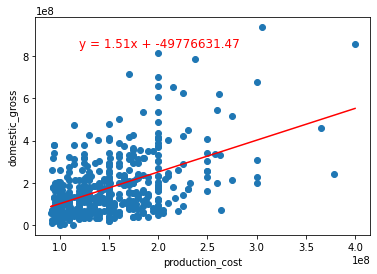

In [103]:
#Get R-squared Value
x_values = movies_df['production_cost']
y_values = movies_df['domestic_gross']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1.2e8,8.4e8),fontsize=12,color="red")
plt.xlabel('production_cost')
plt.ylabel('domestic_gross')
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

In [ ]:
# Analysis Response: 
# The independent variable on y-axis is statistically significant but a low r-squared value of 0.258. This combination 
# indicates the independent variables are correlated with the dependent variable, but they do not explain 
# much of the variability. 20% variance of the dependent variable is explained by the independent variable.

#Diversify Production Budgets: Because high budget films more consistenly have net positive returns 
#but are expensive to produce and lower budget films have a higher returns but a higher rate of failue, 
#we suggest have a mixed portfolio of high and low budget films. 

In [ ]:
#Duration of the movie vs revenue of the movie
#Visualize:  Runtime vs gross revenue (US) using scatter plot;One variable in 90’s and one variable in recent years
#Response: What kind of relatioship is present?

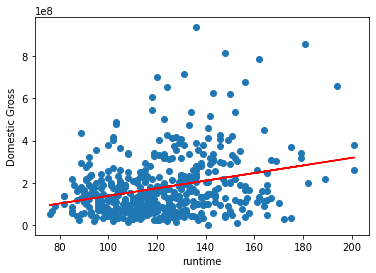

In [86]:
movies_df_nonan = movies_df.dropna(subset=['runtime','domestic_gross'])
x_values = movies_df_nonan['runtime']
y_values = movies_df_nonan['domestic_gross']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=12,color="red")
plt.xlabel('runtime')
plt.ylabel('Domestic Gross')
plt.show()

In [87]:
rvalue

0.28434994331259544

In [ ]:
#Statistically Significant